In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import plotly.express as px
import folium

from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

dataset=pd.read_csv('hotel_bookings.csv')
print(dataset)

               hotel  is_canceled  lead_time  arrival_date_year  \
0       Resort Hotel            0        342               2015   
1       Resort Hotel            0        737               2015   
2       Resort Hotel            0          7               2015   
3       Resort Hotel            0         13               2015   
4       Resort Hotel            0         14               2015   
...              ...          ...        ...                ...   
119385    City Hotel            0         23               2017   
119386    City Hotel            0        102               2017   
119387    City Hotel            0         34               2017   
119388    City Hotel            0        109               2017   
119389    City Hotel            0        205               2017   

       arrival_date_month  arrival_date_week_number  \
0                    July                        27   
1                    July                        27   
2                    July     

In [2]:
#replace missing values:
fillna = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
dataset1 = dataset.fillna(fillna)

dataset1["meal"].replace("Undefined", "SC", inplace=True)

#dropping entries with no guests (=0)
zero_guests = list(dataset1.loc[dataset1["adults"]
                   + dataset1["children"]
                   + dataset1["babies"]==0].index)
dataset1.drop(dataset1.index[zero_guests], inplace=True)

In [3]:
#after cleaning => separate Resort and City hotel
#only bookings that were not canceled are included. 
rh = dataset.loc[(dataset["hotel"] == "Resort Hotel") & (dataset["is_canceled"] == 0)]
ch = dataset.loc[(dataset["hotel"] == "City Hotel") & (dataset["is_canceled"] == 0)]

In [4]:
rh["adr_pp"] = rh["adr"] / (rh["adults"] + rh["children"])
ch["adr_pp"] = ch["adr"] / (ch["adults"] + ch["children"])

<ipython-input-4-fe0f2a2eefb7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rh["adr_pp"] = rh["adr"] / (rh["adults"] + rh["children"])
<ipython-input-4-fe0f2a2eefb7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ch["adr_pp"] = ch["adr"] / (ch["adults"] + ch["children"])


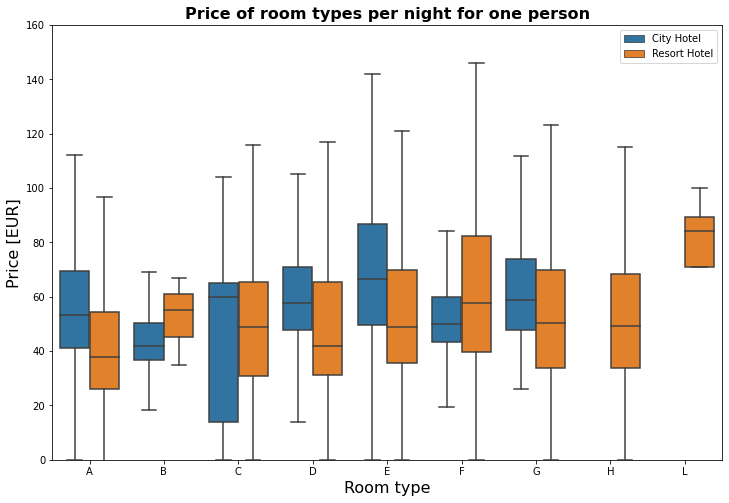

In [5]:
# normalize price per night (adr):
dataset1["adr_pp"] = dataset1["adr"] / (dataset1["adults"] + dataset1["children"])
full_data_guests = dataset1.loc[dataset1["is_canceled"] == 0] # only actual gusts
room_prices = full_data_guests[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")

# boxplot:
plt.figure(figsize=(12, 8))
sns.boxplot(x="reserved_room_type",
            y="adr_pp",
            hue="hotel",
            data=room_prices, 
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)
plt.title("Price of room types per night for one person", fontsize=16, weight='bold')
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price [EUR]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.show()

Text(0, 0.5, 'Count')

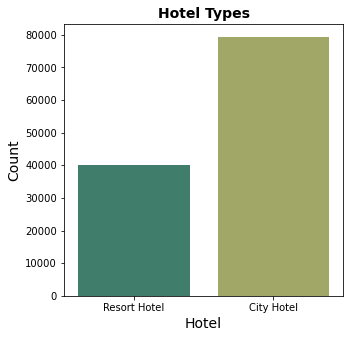

In [6]:
#hotel types

plt.figure(figsize=(5,5))
sns.countplot(x='hotel', data = dataset, palette='gist_earth')
plt.title('Hotel Types', weight='bold', fontsize=14)
plt.xlabel('Hotel', fontsize=14)
plt.ylabel('Count', fontsize=14)

Text(0, 0.5, 'Count')

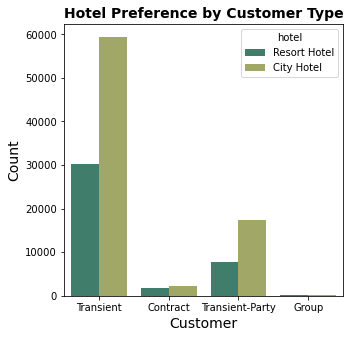

In [7]:
plt.figure(figsize=(5,5))
sns.countplot(x='customer_type', hue="hotel", data = dataset, palette='gist_earth')
plt.title('Hotel Preference by Customer Type', weight='bold', fontsize=14)
plt.xlabel('Customer', fontsize=14)
plt.ylabel('Count', fontsize=14)

Text(0, 0.5, 'Count')

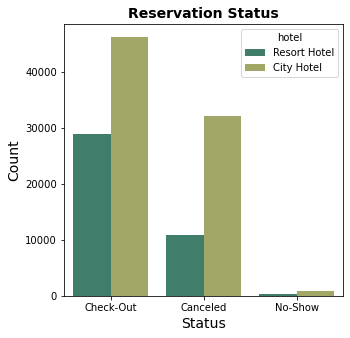

In [8]:
plt.figure(figsize=(5,5))
sns.countplot(x='reservation_status', hue='hotel', data = dataset, palette='gist_earth')
plt.title('Reservation Status', weight='bold', fontsize=14)
plt.xlabel('Status', fontsize=14)
plt.ylabel('Count', fontsize=14)

In [9]:
month_to_number = {"January":1, "February":2, "March":3, "April":4, "May":5, "June":6, "July":7,
                   "August":8, "September":9, "October":10, "November":11, "December":12}

month_numb = []

for i in range(dataset.shape[0]):
    month_numb.append(month_to_number[dataset.iloc[i,4]])

dataset["Month Number"] = month_numb
dataset = dataset.sort_values(["Month Number"])

Text(0, 0.5, 'Count')

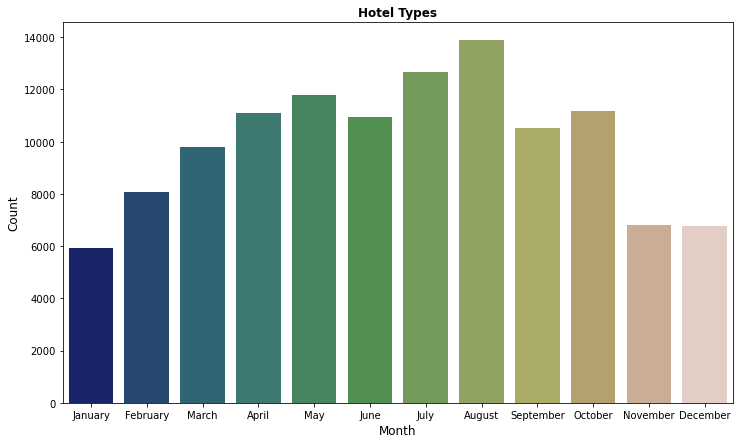

In [10]:
#comparing arrivals each month
plt.figure(figsize=(12,7))
sns.countplot(x='arrival_date_month', data = dataset, palette='gist_earth')
plt.title('Hotel Types', weight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)

In [11]:
dataset.corr()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,Month Number
is_canceled,1.000000,0.293123,0.016660,0.008148,-0.006130,-0.001791,0.024765,0.060017,0.005048,-0.032491,...,0.110133,-0.057358,-0.144381,-0.083114,-0.020642,0.054186,0.047557,-0.195498,-0.234658,0.011022
lead_time,0.293123,1.000000,0.040142,0.126871,0.002268,0.085671,0.165799,0.119519,-0.037622,-0.020915,...,0.086042,-0.073548,0.000149,-0.069741,0.151464,0.170084,-0.063077,-0.116451,-0.095712,0.131424
arrival_date_year,0.016660,0.040142,1.000000,-0.540561,-0.000221,0.021497,0.030883,0.029635,0.054624,-0.013192,...,-0.119822,0.029218,0.030872,0.063457,0.259095,-0.056497,0.197580,-0.013684,0.108531,-0.527739
arrival_date_week_number,0.008148,0.126871,-0.540561,1.000000,0.066809,0.018208,0.015558,0.025909,0.005518,0.010395,...,0.035501,-0.020904,0.005508,-0.031201,-0.076760,0.022933,0.075791,0.001920,0.026149,0.995105
arrival_date_day_of_month,-0.006130,0.002268,-0.000221,0.066809,1.000000,-0.016354,-0.028174,-0.001566,0.014544,-0.000230,...,-0.027011,-0.000300,0.010613,0.001487,0.044858,0.022728,0.030245,0.008683,0.003062,-0.026063
stays_in_weekend_nights,-0.001791,0.085671,0.021497,0.018208,-0.016354,1.000000,0.498969,0.091871,0.045793,0.018483,...,-0.012775,-0.042715,0.063281,0.140739,0.066749,-0.054151,0.049342,-0.018554,0.072671,0.018440
stays_in_week_nights,0.024765,0.165799,0.030883,0.015558,-0.028174,0.498969,1.000000,0.092976,0.044203,0.020191,...,-0.013992,-0.048743,0.096209,0.182382,0.182211,-0.002020,0.065237,-0.024859,0.068192,0.019212
adults,0.060017,0.119519,0.029635,0.025909,-0.001566,0.091871,0.092976,1.000000,0.030447,0.018146,...,-0.006738,-0.107983,-0.051673,-0.035594,0.207793,-0.008283,0.230641,0.014785,0.122884,0.028534
children,0.005048,-0.037622,0.054624,0.005518,0.014544,0.045793,0.044203,0.030447,1.000000,0.024030,...,-0.024730,-0.021072,0.048949,0.041066,0.030931,-0.033273,0.324854,0.056253,0.081745,0.005441
babies,-0.032491,-0.020915,-0.013192,0.010395,-0.000230,0.018483,0.020191,0.018146,0.024030,1.000000,...,-0.007501,-0.006550,0.083440,0.036184,0.019206,-0.010621,0.029186,0.037383,0.097889,0.010172


In [12]:
dataset.corr()["is_canceled"].sort_values()

total_of_special_requests        -0.234658
required_car_parking_spaces      -0.195498
booking_changes                  -0.144381
is_repeated_guest                -0.084793
agent                            -0.083114
previous_bookings_not_canceled   -0.057358
babies                           -0.032491
company                          -0.020642
arrival_date_day_of_month        -0.006130
stays_in_weekend_nights          -0.001791
children                          0.005048
arrival_date_week_number          0.008148
Month Number                      0.011022
arrival_date_year                 0.016660
stays_in_week_nights              0.024765
adr                               0.047557
days_in_waiting_list              0.054186
adults                            0.060017
previous_cancellations            0.110133
lead_time                         0.293123
is_canceled                       1.000000
Name: is_canceled, dtype: float64

In [13]:
dataset = dataset.drop(['arrival_date_week_number'], axis = 1)
dataset = dataset.drop(['arrival_date_day_of_month'], axis = 1)
dataset = dataset.drop(['children'], axis = 1)
dataset = dataset.drop(['company'], axis = 1)
dataset = dataset.drop(['babies'], axis = 1)
dataset = dataset.drop(['meal'], axis = 1)
dataset = dataset.drop(['is_repeated_guest'], axis = 1)
dataset = dataset.drop(['previous_bookings_not_canceled'], axis = 1)
dataset = dataset.drop(['booking_changes'], axis = 1)
dataset = dataset.drop(['reserved_room_type'], axis = 1)
dataset = dataset.drop(['assigned_room_type'], axis = 1)
dataset = dataset.drop(['reservation_status_date'], axis = 1)
dataset = dataset.drop(['total_of_special_requests'], axis = 1)
dataset = dataset.drop(['required_car_parking_spaces'], axis = 1)


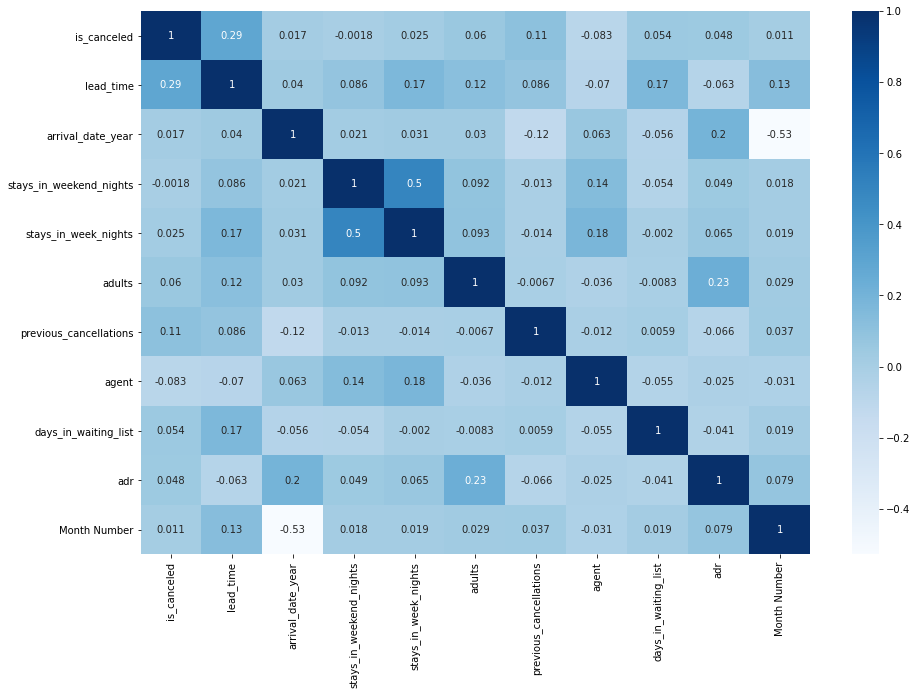

In [14]:
#heatmap with the annotation argument
plt.rcParams['figure.figsize'] = (15.0, 10.0)
sns.heatmap(dataset.corr(),cmap="Blues", annot=True)